In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from Ska.engarchive import fetch_sci as fetch
from mica.archive.aca_l0 import get_l0_images
from kadi import events
from scipy import optimize
import cPickle
import os.path

In [2]:
def gaussian(height, coff, roff, sigma):
    """Returns a gaussian function with the given parameters"""
    sigma = float(sigma)
    return lambda x, y: height * np.exp(-(((c - coff) / sigma)**2 + ((r - roff) / sigma)**2) / 2)


def fitgaussian(data, params):
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) - data)
    p, success = optimize.leastsq(errorfunction, params)
    return p    

In [3]:
p0 = [1000., 0., 0., 2.]

In [4]:
dwells = events.dwells.filter('2017:100', '2017:101')

In [5]:
fwhm_file = 'fwhm.pickle'
if not os.path.isfile(fwhm_file):
    rows = []
    for d in dwells:    
        for slot in [3, 4, 5 ,6 , 7]:
            imgs = get_l0_images(d.start, d.stop, imgsize=[6, 8], slot=slot)
            if len(imgs) > 1000:
                mag = fetch.MSID('aoacmag{}'.format(slot), d.start, d.stop)
                row = {'mag': np.mean(mag.vals), 'slot': slot, 'obsid': d.get_obsid()}
                fwhms = []
                for img in imgs:
                    sz = np.int(img.IMGSIZE / 2)
                    r, c = np.mgrid[-sz:sz, -sz:sz] - 0.5
                    data = img - img.BGDAVG
                    if img.IMGSIZE == 6:
                        data[[0, 0, 5, 5], [0, 5, 0, 5]]
                    params = fitgaussian(data, p0)
                    fwhm = params[-1] * 2. * np.sqrt(2. * np.log(2.))
                    fwhms.append(fwhm)
                    row['fwhm_dist'] = fwhms
                    row['median'] = np.median(fwhms)
                    row['imgsize'] = img.IMGSIZE
                rows.append(row)
    tab = Table(rows)
    cPickle.dump(tab, open(fwhm_file, 'w'))
else:
    tab = cPickle.load(open('fwhm.pickle'))

In [6]:
tab.colnames

['fwhm_dist', 'imgsize', 'mag', 'median', 'obsid', 'slot']

In [7]:
print(tab['obsid', 'mag', 'median', 'slot', 'imgsize'])

obsid   mag       median    slot imgsize
----- ------- ------------- ---- -------
50157 8.05064 2.78208461582    3       8
50157 7.81329 2.76639134175    4       8
50157 8.59461 2.81804594102    5       8
50157  8.2559 2.81776714856    6       8
50157 9.08853 2.84820736552    7       8
50156  9.0226 2.82789348764    3       8
50156 6.87497 2.70584758674    4       8
50156 8.27831 2.74930957459    5       8
50156 8.86835 2.87040113489    6       8
50156 8.58273 2.81657338858    7       8
19921 7.76662 2.74489011003    3       6
19921 8.25272 2.74519937506    4       6
19921 8.34421 2.78174621713    5       6
19921 8.33393 2.78401212184    6       6
19921 6.94087 2.66867231853    7       6
20041 6.97204 2.68178851307    3       6
20041 7.98396 2.74247748518    4       6
20041 7.47551 2.67345448528    5       6
20041 8.15111 2.74544228096    6       6
20041 7.89927 2.82071716261    7       6


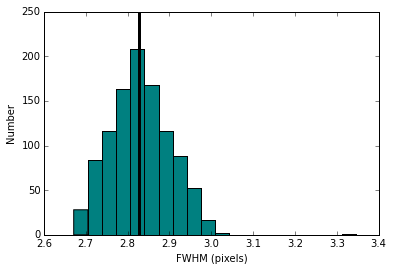

In [8]:
plt.hist(tab['fwhm_dist'][5], 20, color='teal')
plt.xlabel('FWHM (pixels)')
plt.vlines([tab['median'][5]], 0, 250, lw=3)
plt.ylabel('Number');

In [9]:
np.median(tab['median'])

2.7740687794403072